In [119]:
import pandas as pd
import numpy as np
import sklearn as sk
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'])
df.head()

/Users/juanito/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [80]:
df.columns = df.columns.str.strip()
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [39]:
print('---------------------------\nInformación general:\n---------------------------')
df.info()
print('\n---------------------------\nValores únicos por columna:\n---------------------------\n',df.nunique())


---------------------------
Información general:
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA     

In [61]:
print('---------------------------\nInformación np.nan:\n---------------------------\n',df.isna().sum())

print('---------------------------\nInformación duplicada:\n---------------------------\n',np.where(df.duplicated()==True)[0])


---------------------------
Información np.nan:
---------------------------
 Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64
---------------------------
Información duplicada:
---------------------------
 []


In [145]:
df = df[df['Vlo-O'].notna()]
df["Vlo-O"]=df["Vlo-O"].astype(str)
df["Vlo-I"]=df["Vlo-I"].astype(str)

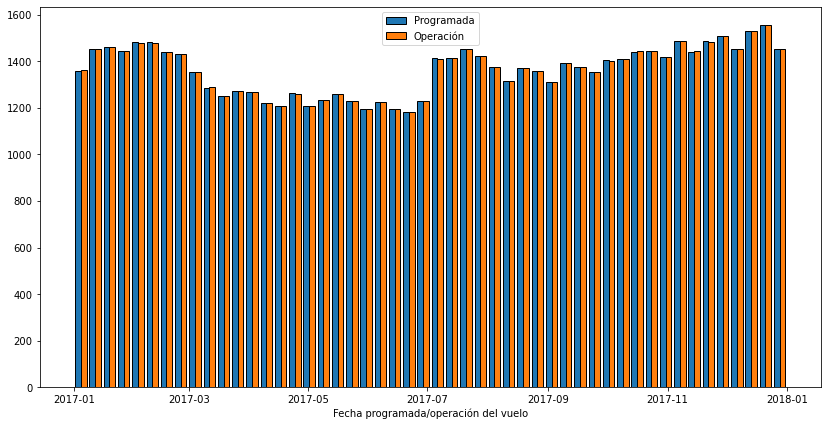

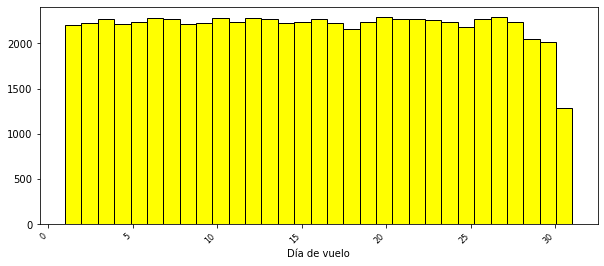

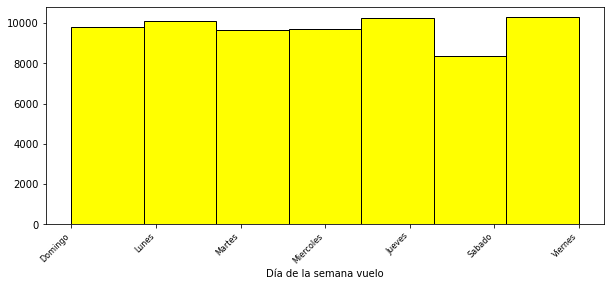

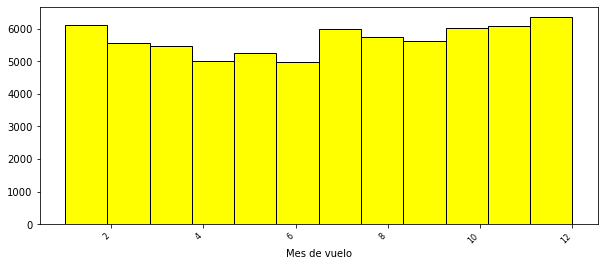

In [186]:
plt.figure(1,figsize=(14,7))
plt.hist([df['Fecha-I'],df['Fecha-O']],50,edgecolor='black')#,color='yellow')
plt.xlabel('Fecha programada/operación del vuelo')
plt.legend(['Programada','Operación'])
plt.show()

plt.figure(2,figsize=(10,4))
plt.hist(df['DIA'],31,edgecolor='black',color='yellow')
plt.xlabel('Día de vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(3,figsize=(10,4))
plt.hist(df['DIANOM'],7,edgecolor='black',color='yellow')
plt.xlabel('Día de la semana vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(4,figsize=(10,4))
plt.hist(df['MES'],12,edgecolor='black',color='yellow')
plt.xlabel('Mes de vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()


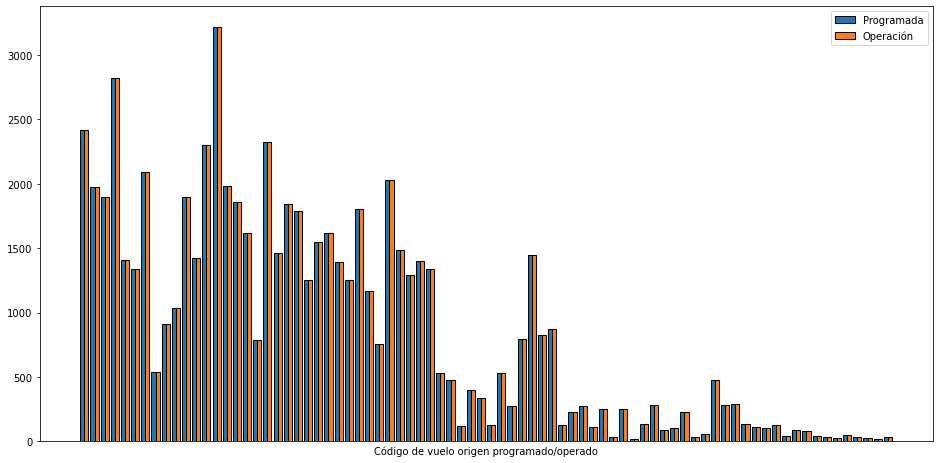

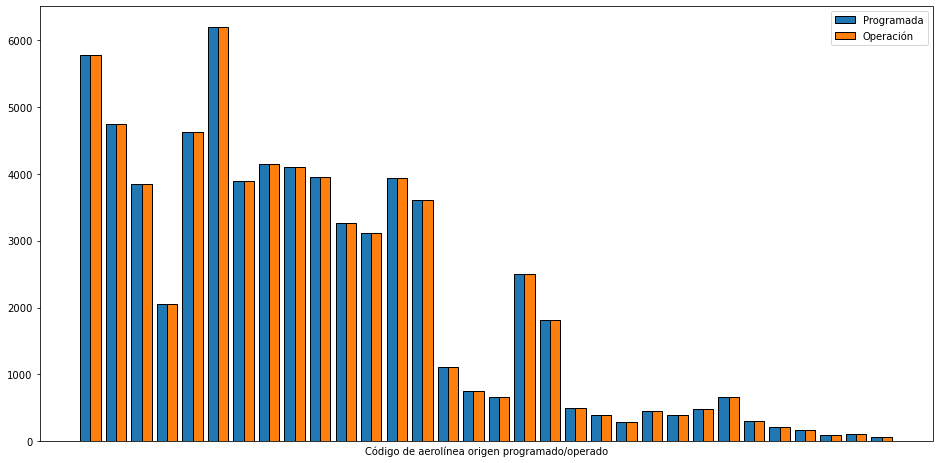

In [213]:
plt.figure(1,figsize=(16,8))
plt.hist([df['Vlo-I'],df['Vlo-I']],80,edgecolor='black')
plt.xlabel('Código de vuelo origen programado/operado')
plt.legend(['Programada','Operación'])
plt.xticks([])
plt.show()

plt.figure(1,figsize=(16,8))
plt.hist([df['Vlo-I'],df['Vlo-I']],32,edgecolor='black')
plt.xlabel('Código de aerolínea origen programado/operado')
plt.legend(['Programada','Operación'])
plt.xticks([])
plt.show()

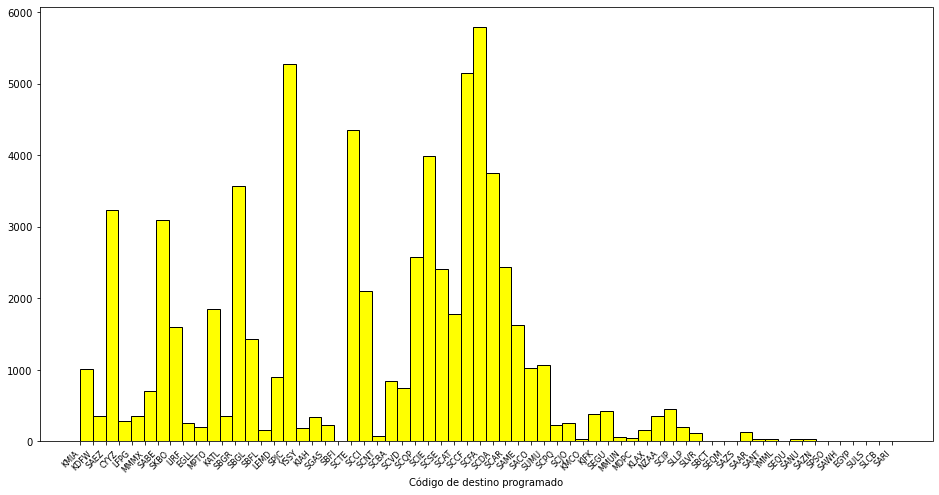

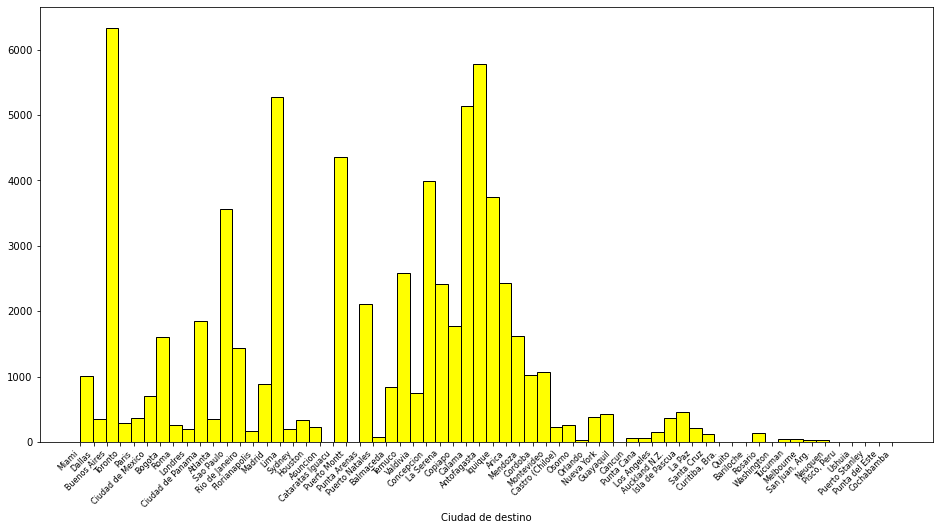

In [179]:
plt.figure(1,figsize=(16,8))
plt.hist(df['Des-I'],64,edgecolor='black',color='yellow')
plt.xlabel('Código de destino programado')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(2,figsize=(16,8))
plt.hist(df['SIGLADES'],64,edgecolor='black',color='yellow')
plt.xlabel('Ciudad de destino')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()


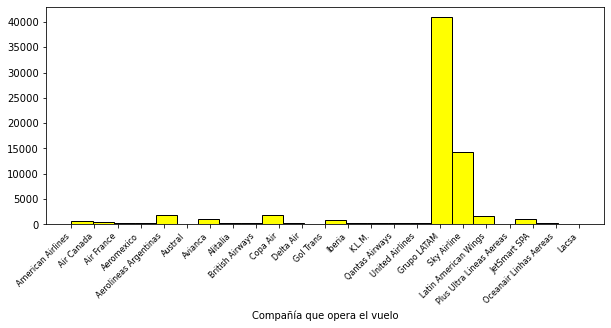

In [212]:
plt.figure(1,figsize=(10,4))
plt.hist(df['OPERA'],24,edgecolor='black',color='yellow')
plt.xlabel('Compañía que opera el vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

[]

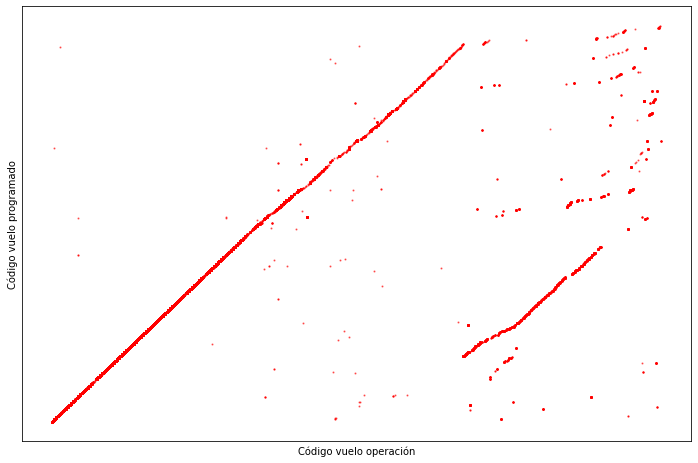

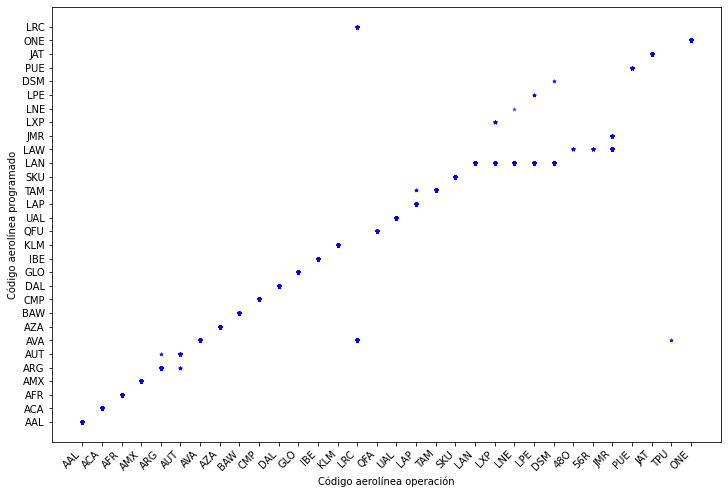

In [218]:
plt.figure(1,figsize=(12,8))
plt.xlabel(r'Código vuelo operación')
plt.ylabel(r'Código vuelo programado')
plt.scatter(df["Vlo-O"],df['Vlo-I'],marker='.',alpha=0.5,s=5,c='red')
plt.xticks([])
plt.yticks([])
plt.plot()

plt.figure(2,figsize=(12,8))
plt.xlabel(r'Código aerolínea operación')
plt.ylabel(r'Código aerolínea programado')
#plt.scatter(df[,df['Vlo-I'].astype(str),marker='.',alpha=0.5,c='red')
plt.scatter(df["Emp-O"],df['Emp-I'],marker='*',alpha=0.5,s=10,c='blue')
plt.xticks(rotation=45, ha="right")#,fontsize=8)
#plt.yticks([])
plt.plot()

In [219]:
dif_min = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60

In [261]:
col = df['Fecha-O']
print(min(col),max(col))

dif_min = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60
dif_min = np.round(dif_min,3)

I1 = np.where((col > '2017-12-15'))[0]
I2 = np.where((col > '2017-9-11') & (col < '2017-9-30'))[0]
I3 = np.where((col > '2017-7-15') & (col < '2017-7-31'))[0]
I4 = np.where((col > '2017-1-1') & (col < '2017-3-3'))[0]
temporada_alta = np.zeros(np.shape(col))
temporada_alta[I1] = 1
temporada_alta[I2] = 1
temporada_alta[I3] = 1
temporada_alta[I4] = 1

atraso_15 = np.zeros(np.shape(col))
atraso_15[dif_min>15] = 1

periodo_dia = np.zeros(np.shape(col),dtype=object)
I1 = np.where((col.dt.hour >= 5) & (col.dt.hour < 12))[0]
I2 = np.where((col.dt.hour >= 12) & (col.dt.hour < 19))[0]
I3 = np.where((col.dt.hour >= 19) | (col.dt.hour < 5))[0]
periodo_dia[I1] = 'mañana'
periodo_dia[I2] = 'tarde'
periodo_dia[I3] = 'noche'

2017-01-01 00:04:00 2018-01-01 00:12:00


In [262]:
synth = pd.DataFrame({'dif_min' : dif_min, 'atraso_15' : atraso_15, 'temporada_alta' : temporada_alta,
                      'periodo_dia':periodo_dia})
synth.to_csv(r'synthetic_features.csv')